In [1]:
import sys

sys.path.append("../input/sentence-transformers")


In [2]:
import transformers
import sentence_transformers

print("Transformers:", transformers.__version__)
print("Sentence Transformers:", sentence_transformers.__version__)


Transformers: 4.27.3
Sentence Transformers: 2.2.2


In [3]:
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()


In [4]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [5]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [6]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        assert model_name in ['PhoBERT_Description', 'BERT4News_Description', 'ViBERT_Description']
        
        self.model_name = model_name
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.desc_size = 768
        
        if 'PhoBERT' in model_name:
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        else:
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size + self.desc_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
    def forward(self, input_ids, attention_mask, description):
        last_hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        conc = torch.cat((output, description), 1)
        x = self.drop(conc)
        x = self.fc(x)
        return x
    

In [7]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [8]:
import os
import gc
import json
import torch
from torch import nn
import numpy as np
from scipy import interpolate
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot


def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []

    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)

        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]

        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            description = data[f'encoded_description_{task}'].to(device)
            labels = data[label_column].to(device)
            
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())
            
    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)
    
    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    if len(history['train_loss']) <= 1:
        return False
    
    colors = plt.get_cmap('tab10').colors
    
    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)
    
    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))
    
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)
    
    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    

def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()
    

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [10]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

# PhoBERT

In [11]:
from sentence_transformers import SentenceTransformer

model_dir = '../input/vispam-description-embedding-phobert/'
sentence_model_1 = SentenceTransformer(model_dir + 'training_nli_vinai-phobert-base-task-1-tokenized', device=device)
sentence_model_2 = SentenceTransformer(model_dir + 'training_nli_vinai-phobert-base-task-2-tokenized', device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

vispam_datasets = vispam_datasets.map(encode_description, batched=True)


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_comment(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_comment, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


## Task 1

In [14]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

model = ViSpam_Classifier(model_name="PhoBERT_Description", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8396 - Train F1-score: 0.8006 - Train Loss: 0.3901
Valid Accuracy: 0.8823 - Valid F1-score: 0.8370 - Valid Loss: 0.4314
Validation loss decreased (inf --> 0.431385). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9021 - Train F1-score: 0.8763 - Train Loss: 0.2861
Valid Accuracy: 0.9037 - Valid F1-score: 0.8723 - Valid Loss: 0.3279
Validation loss decreased (0.431385 --> 0.327941). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9289 - Train F1-score: 0.9094 - Train Loss: 0.2278
Valid Accuracy: 0.9018 - Valid F1-score: 0.8695 - Valid Loss: 0.4539
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9499 - Train F1-score: 0.9357 - Train Loss: 0.1822
Valid Accuracy: 0.8980 - Valid F1-score: 0.8607 - Valid Loss: 0.5713
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9631 - Train F1-score: 0.9528 - Train Loss: 0.1419
Valid Accuracy: 0.8943 - Valid F1-score: 0.8590 - Valid Loss: 0.5611
EarlyStopping counter: 3 out of 3
Early stopping.


In [15]:
save_visualization_history(history, 'PhoBERT_Description', task=1)
plotting_history(history)


In [16]:
import os
import torch

model_name = "PhoBERT_Description"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.9011
Precision: 0.8751
Recall: 0.8695
F1-score: 0.8722
Confusion matrix:
 [[2727  184]
 [ 208  844]]
              precision    recall  f1-score   support

           0     0.9291    0.9368    0.9329      2911
           1     0.8210    0.8023    0.8115      1052

    accuracy                         0.9011      3963
   macro avg     0.8751    0.8695    0.8722      3963
weighted avg     0.9004    0.9011    0.9007      3963



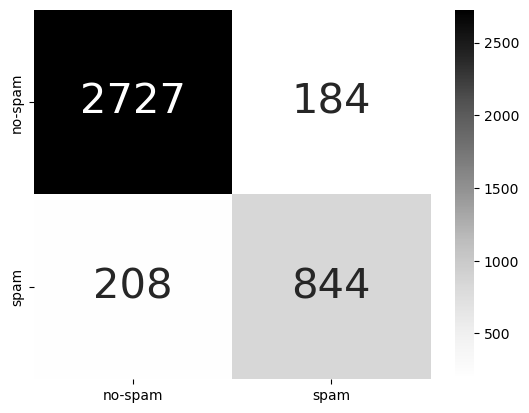

In [17]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [18]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

model = ViSpam_Classifier(model_name="PhoBERT_Description", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7532 - Train F1-score: 0.5779 - Train Loss: 0.8108
Valid Accuracy: 0.8729 - Valid F1-score: 0.6695 - Valid Loss: 0.8546
Validation loss decreased (inf --> 0.854582). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8616 - Train F1-score: 0.7286 - Train Loss: 0.5509
Valid Accuracy: 0.8452 - Valid F1-score: 0.6080 - Valid Loss: 0.8287
Validation loss decreased (0.854582 --> 0.828733). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8977 - Train F1-score: 0.7794 - Train Loss: 0.4532
Valid Accuracy: 0.8773 - Valid F1-score: 0.6553 - Valid Loss: 0.8230
Validation loss decreased (0.828733 --> 0.823036). Saving model ...
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9237 - Train F1-score: 0.8390 - Train Loss: 0.3473
Valid Accuracy: 0.8930 - Valid F1-score: 0.6996 - Valid Loss: 1.0564
EarlyStopping counter: 1 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9423 - Train F1-score: 0.8664 - Train Loss: 0.3028
Valid Accuracy: 0.8930 - Valid F1-score: 0.6808 - Valid Loss: 1.4600
EarlyStopping counter: 2 out of 3
Epoch 6/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9581 - Train F1-score: 0.9022 - Train Loss: 0.2504
Valid Accuracy: 0.8855 - Valid F1-score: 0.6628 - Valid Loss: 1.3928
EarlyStopping counter: 3 out of 3
Early stopping.


In [19]:
save_visualization_history(history, 'PhoBERT_Description', task=2)
plotting_history(history)


In [20]:
import os
import torch

model_name = "PhoBERT_Description"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8806
Precision: 0.7492
Recall: 0.7241
F1-score: 0.7349
Confusion matrix:
 [[2710   11  139   51]
 [  17   30    1    6]
 [ 120    1  180    8]
 [  92    4   23  570]]
              precision    recall  f1-score   support

           0     0.9221    0.9310    0.9265      2911
           1     0.6522    0.5556    0.6000        54
           2     0.5248    0.5825    0.5521       309
           3     0.8976    0.8273    0.8610       689

    accuracy                         0.8806      3963
   macro avg     0.7492    0.7241    0.7349      3963
weighted avg     0.8832    0.8806    0.8815      3963



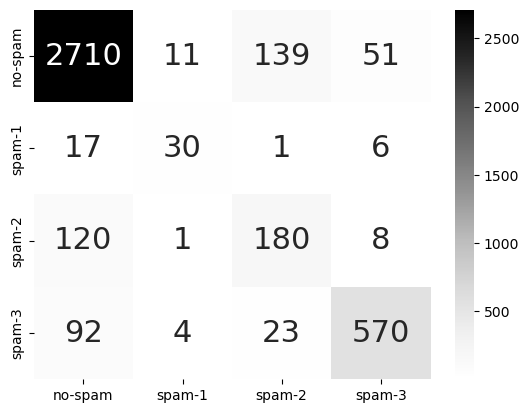

In [21]:
plotting_confusion_matrix(test_cm, task=2)


# BERT4News

In [22]:
from sentence_transformers import SentenceTransformer

model_dir = '../input/vispam-bert4news-description-embedding/'
sentence_model_1 = SentenceTransformer(model_dir + 'training_nli_NlpHUST-vibert4news-base-cased-task-1', device=device)
sentence_model_2 = SentenceTransformer(model_dir + 'training_nli_NlpHUST-vibert4news-base-cased-task-2', device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

vispam_datasets = vispam_datasets.map(encode_description, batched=True)


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [23]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

def encode_comment(examples):
    return tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_comment, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [24]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


## Task 1

In [25]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

model = ViSpam_Classifier(model_name="BERT4News_Description", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8559 - Train F1-score: 0.8198 - Train Loss: 0.3819
Valid Accuracy: 0.8899 - Valid F1-score: 0.8499 - Valid Loss: 0.4383
Validation loss decreased (inf --> 0.438274). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9171 - Train F1-score: 0.8948 - Train Loss: 0.2546
Valid Accuracy: 0.8874 - Valid F1-score: 0.8518 - Valid Loss: 0.4481
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9490 - Train F1-score: 0.9349 - Train Loss: 0.1714
Valid Accuracy: 0.8785 - Valid F1-score: 0.8463 - Valid Loss: 0.4862
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9732 - Train F1-score: 0.9656 - Train Loss: 0.1029
Valid Accuracy: 0.8918 - Valid F1-score: 0.8539 - Valid Loss: 0.8628
EarlyStopping counter: 3 out of 3
Early stopping.


In [26]:
save_visualization_history(history, 'BERT4News_Description', task=1)
plotting_history(history)


In [27]:
import os
import torch

model_name = "BERT4News_Description"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8923
Precision: 0.8679
Recall: 0.8505
F1-score: 0.8586
Confusion matrix:
 [[2735  176]
 [ 251  801]]
              precision    recall  f1-score   support

           0     0.9159    0.9395    0.9276      2911
           1     0.8199    0.7614    0.7896      1052

    accuracy                         0.8923      3963
   macro avg     0.8679    0.8505    0.8586      3963
weighted avg     0.8904    0.8923    0.8909      3963



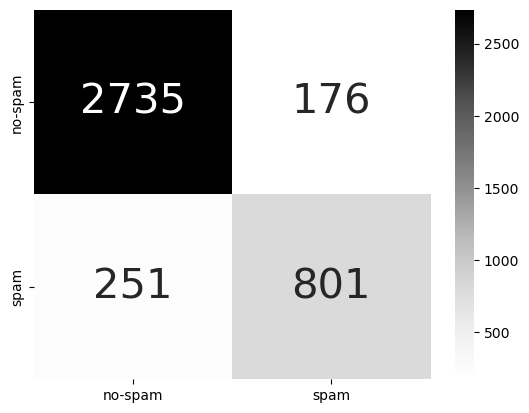

In [28]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [29]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

model = ViSpam_Classifier(model_name="BERT4News_Description", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7974 - Train F1-score: 0.6356 - Train Loss: 0.7440
Valid Accuracy: 0.8735 - Valid F1-score: 0.6552 - Valid Loss: 0.8440
Validation loss decreased (inf --> 0.843964). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8843 - Train F1-score: 0.7591 - Train Loss: 0.4784
Valid Accuracy: 0.8704 - Valid F1-score: 0.6223 - Valid Loss: 1.0107
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9312 - Train F1-score: 0.8495 - Train Loss: 0.3345
Valid Accuracy: 0.8792 - Valid F1-score: 0.6486 - Valid Loss: 1.1055
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9573 - Train F1-score: 0.9039 - Train Loss: 0.2184
Valid Accuracy: 0.8754 - Valid F1-score: 0.6670 - Valid Loss: 1.4059
EarlyStopping counter: 3 out of 3
Early stopping.


In [30]:
save_visualization_history(history, 'BERT4News_Description', task=2)
plotting_history(history)


In [31]:
import os
import torch

model_name = "BERT4News_Description"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8751
Precision: 0.7179
Recall: 0.7221
F1-score: 0.7189
Confusion matrix:
 [[2693   18  153   47]
 [  17   30    0    7]
 [ 119    1  183    6]
 [ 106    8   13  562]]
              precision    recall  f1-score   support

           0     0.9175    0.9251    0.9213      2911
           1     0.5263    0.5556    0.5405        54
           2     0.5244    0.5922    0.5562       309
           3     0.9035    0.8157    0.8574       689

    accuracy                         0.8751      3963
   macro avg     0.7179    0.7221    0.7189      3963
weighted avg     0.8791    0.8751    0.8765      3963



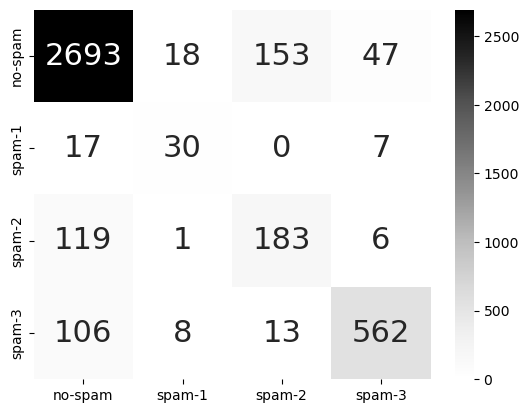

In [32]:
plotting_confusion_matrix(test_cm, task=2)
